In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
import numpy as np
import pandas as pd
from pytz import UTC

from logbook import (NestedSetup, NullHandler, Logger, StreamHandler, StderrHandler, 
                     INFO, WARNING, DEBUG, ERROR)

from zipline import run_algorithm
from zipline.api import (attach_pipeline, 
                         date_rules, 
                         time_rules,
                         get_datetime,
                         order_target_percent,
                         pipeline_output, 
                         record, 
                         schedule_function, 
                         get_open_orders, 
                         calendars,
                         set_commission, 
                         set_slippage)
from zipline.finance import commission, slippage
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.factors import Returns, AverageDollarVolume

from pyfolio.utils import extract_rets_pos_txn_from_zipline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# setup stdout logging
format_string = '[{record.time: %H:%M:%S.%f}]: {record.level_name}: {record.message}'
zipline_logging = NestedSetup([NullHandler(level=DEBUG),
                               StreamHandler(sys.stdout, format_string=format_string, level=INFO),
                               StreamHandler(sys.stderr, level=ERROR)])
zipline_logging.push_application()
log = Logger('Algorithm')

In [2]:
# Settings
MONTH = 21
YEAR = 12 * MONTH
N_LONGS = 50
N_SHORTS = 50
VOL_SCREEN = 500

#start = pd.Timestamp('2013-01-01', tz=UTC)
#end = pd.Timestamp('2017-01-01', tz=UTC)
start = pd.Timestamp('2013-01-01')
end = pd.Timestamp('2017-01-01')
capital_base = 1e7

In [3]:
class MeanReversion(CustomFactor):
    """Compute ratio of latest monthly return to 12m average, normalized by std dev of monthly returns"""
    inputs = [Returns(window_length=MONTH)]
    window_length = YEAR

    def compute(self, today, assets, out, monthly_returns):
        df = pd.DataFrame(monthly_returns)
        out[:] = df.iloc[-1].sub(df.mean()).div(df.std())

def compute_factors():
    """Create factor pipeline incl. mean reversion, filtered by 30d Dollar Volume; capture factor ranks"""
    mean_reversion = MeanReversion()
    dollar_volume = AverageDollarVolume(window_length=30)
    return Pipeline(columns={'longs'  : mean_reversion.bottom(N_LONGS),
                             'shorts' : mean_reversion.top(N_SHORTS),
                             'ranking': mean_reversion.rank(ascending=False)},
                    screen=dollar_volume.top(VOL_SCREEN))

def exec_trades(data, assets, target_percent):
    """Place orders for assets using target portfolio percentage"""
    for asset in assets:
        if data.can_trade(asset) and not get_open_orders(asset):
            order_target_percent(asset, target_percent)

def rebalance(context, data):
    """Compute long, short and obsolete holdings; place trade orders"""
    factor_data = context.factor_data
    assets = factor_data.index
    
    longs = assets[factor_data.longs]
    shorts = assets[factor_data.shorts]
    divest = context.portfolio.positions.keys() - longs.union(shorts)
    log.info('{} | Longs: {:2.0f} | Shorts: {:2.0f} | {:,.2f}'.format(get_datetime().date(),
                                                                     len(longs), 
                                                                     len(shorts),
                                                                     context.portfolio.portfolio_value))

    exec_trades(data, assets=divest, target_percent=0)
    exec_trades(data, assets=longs, target_percent=1 / N_LONGS if N_LONGS else 0)
    exec_trades(data, assets=shorts, target_percent=-1 / N_SHORTS if N_SHORTS else 0)
    
    ## 这里打印的仓位，还是上个周期的；本周期实际仓位调整时机，在schedule_function注册的函数之后
    #log.info(context.portfolio)                            # 打印持仓的详细信息
    #log.info(context.portfolio.current_portfolio_weights)  # 打印仓位权重
            
def initialize(context):
    """Setup: register pipeline, schedule rebalancing, and set trading params"""
    attach_pipeline(compute_factors(), 'factor_pipeline')
    schedule_function(rebalance,
                      date_rules.week_start(), #因子每天都算，但只每周调一次仓
                      time_rules.market_open(),
                      calendar=calendars.US_EQUITIES)

    set_commission(us_equities=commission.PerShare(cost=0.00075, min_trade_cost=.01))
    set_slippage(us_equities=slippage.VolumeShareSlippage(volume_limit=0.0025, price_impact=0.01))
    
def before_trading_start(context, data):
    """Run factor pipeline"""
    context.factor_data = pipeline_output('factor_pipeline')
    record(factor_data=context.factor_data.ranking)
    assets = context.factor_data.index
    record(prices=data.current(assets, 'price'))
    
backtest = run_algorithm(start=start,
                         end=end,
                         initialize=initialize,
                         before_trading_start=before_trading_start,
                         bundle='quandl',
                         capital_base=capital_base)

[ 13:48:03.331054]: INFO: this is initialize
[ 13:48:06.081666]: INFO: 2013-01-07 | Longs: 10 | Shorts:  2 | 10,000,000.00
[ 13:48:09.744193]: INFO: 2013-01-14 | Longs: 13 | Shorts:  3 | 10,027,422.36
[ 13:48:10.369235]: INFO: 2013-01-22 | Longs:  8 | Shorts:  5 | 10,097,663.57
[ 13:48:10.873268]: INFO: 2013-01-28 | Longs:  5 | Shorts: 14 | 10,106,150.06
[ 13:48:11.511554]: INFO: 2013-02-04 | Longs: 12 | Shorts: 11 | 10,135,417.26
[ 13:48:12.156376]: INFO: 2013-02-11 | Longs: 11 | Shorts: 13 | 10,182,644.42
[ 13:48:12.821403]: INFO: 2013-02-19 | Longs: 21 | Shorts: 11 | 10,127,755.45
[ 13:48:13.393491]: INFO: 2013-02-25 | Longs: 16 | Shorts:  8 | 10,180,357.23
[ 13:48:14.082667]: INFO: 2013-03-04 | Longs: 10 | Shorts: 10 | 10,200,300.19
[ 13:48:14.735338]: INFO: 2013-03-11 | Longs: 12 | Shorts:  7 | 10,240,453.13
[ 13:48:15.380497]: INFO: 2013-03-18 | Longs:  7 | Shorts:  7 | 10,150,394.01
[ 13:48:16.005501]: INFO: 2013-03-25 | Longs:  8 | Shorts:  7 | 10,149,029.25
[ 13:48:16.516604]:

In [4]:
returns, positions, transactions = extract_rets_pos_txn_from_zipline(backtest)

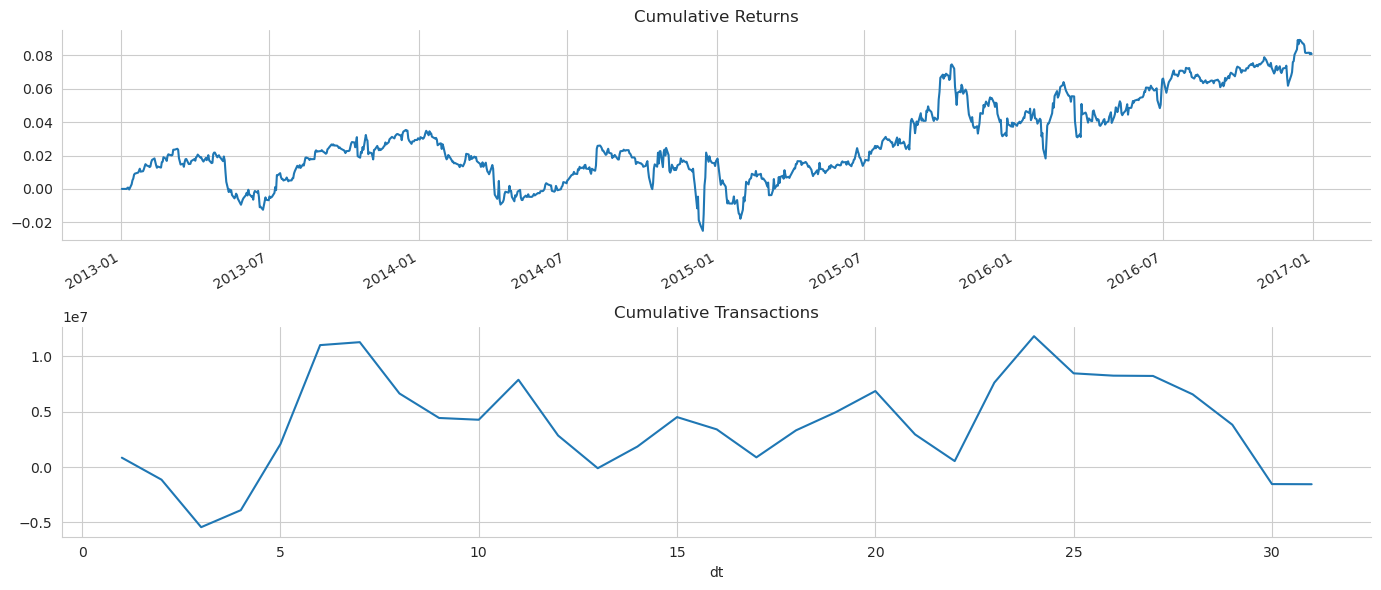

In [10]:
fig, axes= plt.subplots(nrows=2, figsize=(14,6))
returns.add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Returns')
transactions.groupby(transactions.dt.dt.day).txn_dollars.sum().cumsum().plot(ax=axes[1], title='Cumulative Transactions')
fig.tight_layout()
sns.despine();

In [13]:
transactions.info()
transactions.head(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6505 entries, 2013-01-08 21:00:00+00:00 to 2016-12-30 21:00:00+00:00
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   sid          6505 non-null   object             
 1   symbol       6505 non-null   object             
 2   price        6505 non-null   float64            
 3   order_id     6502 non-null   object             
 4   amount       6505 non-null   int64              
 5   commission   0 non-null      object             
 6   dt           6505 non-null   datetime64[ns, UTC]
 7   txn_dollars  6505 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(2), int64(1), object(4)
memory usage: 457.4+ KB


,sid,symbol,price,order_id,amount,commission,dt,txn_dollars
2013-01-08 21:00:00+00:00,Equity(85 [AGN]),Equity(85 [AGN]),86.680005,3cd5511c2f5d4430b699b130f3988865,2334,None,2013-01-08 21:00:00+00:00,-202311.131306
2013-01-08 21:00:00+00:00,Equity(213 [ARIA]),Equity(213 [ARIA]),19.651001,b6a298dc69484173a41abcceed0743ee,7590,None,2013-01-08 21:00:00+00:00,-149151.099321
2013-01-08 21:00:00+00:00,Equity(367 [BIIB]),Equity(367 [BIIB]),144.390001,95820bb8024b4d49bd6d906e7786df0d,1365,None,2013-01-08 21:00:00+00:00,-197092.351185
2013-01-08 21:00:00+00:00,Equity(811 [DFS]),Equity(811 [DFS]),40.090001,695d275fa30f4ccf9790acda226d5a69,5073,None,2013-01-08 21:00:00+00:00,-203376.572741
2013-01-08 21:00:00+00:00,Equity(1059 [FDO]),Equity(1059 [FDO]),57.320002,b653a9a231ce4fdb9b385754118a4619,3496,None,2013-01-08 21:00:00+00:00,-200390.728571
2013-01-08 21:00:00+00:00,Equity(1093 [FL]),Equity(1093 [FL]),33.160002,201b31907f784c668f85de020ab484b7,6041,None,2013-01-08 21:00:00+00:00,-200319.572518
2013-01-08 21:00:00+00:00,Equity(1321 [HD]),Equity(1321 [HD]),63.220000,a28fd2b8d79948eb96910daec20d0c36,3182,None,2013-01-08 21:00:00+00:00,-201166.040690
2013-01-08 21:00:00+00:00,Equity(1353 [HLF]),Equity(1353 [HLF]),38.350000,ef26d4d74ee842379e8cd5595170621a,5468,None,2013-01-08 21:00:00+00:00,-209697.800429
2013-01-08 21:00:00+00:00,Equity(1648 [LB]),Equity(1648 [LB]),44.070000,5d85773a56434ffeb172822637cccf51,4478,None,2013-01-08 21:00:00+00:00,-197345.461406
2013-01-08 21:00:00+00:00,Equity(1882 [MRK]),Equity(1882 [MRK]),42.180000,c2d9d8effe06437c9d10f10cddea6c3a,4748,None,2013-01-08 21:00:00+00:00,-200270.640207


In [ ]:
return